In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os
import openpyxl
import re
import seaborn as sns

pd.set_option("display.min_rows", 10)
pd.set_option('display.max_columns', None)

In [2]:
class GetDataFrame:
    EQUIPMENT_LIST = ("CW500Viewer", "equip2")

    def __init__(self, equip_model: str, file_path: str):
        if equip_model not in self.EQUIPMENT_LIST:
            raise ValueError(f"equip_model must be one of {self.EQUIPMENT_LIST}. Got: {equip_model}")

        self.equip_model = equip_model
        self.file_path = file_path
        self.df = None  

    def load(self, phase='') -> pd.DataFrame:
        if self.equip_model == "CW500Viewer":
            self.df = self._get_and_clean_cw500_df()
            return self.df
            
        elif self.equip_model == "equip2":
            self.df = self._get_and_clean_equip2_df(phase)
            return self.df
  
        raise ValueError(f"Unsupported equip_model: {self.equip_model}")

    def _get_and_clean_cw500_df(self) -> pd.DataFrame:
        df = pd.read_csv(self.file_path, sep=';', decimal=',', skiprows=37, index_col=0)
        df = df.drop(columns=['ELAPSED TIME','Unnamed: 53'])
        df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y/%m/%d %H:%M:%S")

        num_cols = df.columns[2:]
        df[num_cols] = df[num_cols].astype(float)

        return df
        
    @staticmethod
    def rename_columns(df, phase='Ia avg'):
        if phase == 'Ia avg' or phase == 'ChA':
            _phase = 'I1'
        elif phase == 'Ib avg' or phase == 'ChB':
            _phase = 'I2'
        elif phase == 'Ic avg' or phase == 'ChC':
            _phase = 'I3'
        else:
            raise ValueError(f"phase not found: {phase}")
            
        new_cols = {}
        cols = []
        for col in df.columns:
            if (phase not in col) or ('HarmV' in col):
                continue
            if col.startswith('HarmI'):
                num = col[5:7]
            elif col.startswith('H') and not col.startswith(('HarmI')):
                num = col[1:3]
                   
            new_col = f'AVG[{num}]_{_phase}[A]'
            new_cols[col] = new_col
            cols.append(new_col)
        
        df = df.rename(columns=new_cols)  
        cols_with_datetime = ['DateTime'] + cols
        
        return df[cols_with_datetime]
        
    @staticmethod
    def percent_to_decimal(df):
        """
        Converts percentage columns to decimals relative to the first numeric column of the DataFrame.
        Assumes the first column is 'DateTime' and the second column is the fundamental value.
        """
        # Fundamental column (second column)
        fundamental_col = df.columns[1]
    
        # Percentage columns (all columns after the second)
        percentage_cols = df.columns[2:]
    
        # Convert percentages to decimals
        df.loc[:, percentage_cols] = df.loc[:, percentage_cols].apply(
            lambda x: x * df[fundamental_col]
        )
        return df

    def _get_and_clean_equip2_df(self, phase) -> pd.DataFrame:
        df = pd.read_excel(path)
        if "Registro" in df.columns:
            df = df.rename(columns={'Registro': 'DateTime'})
        elif "time" in df.columns:
            df = df.rename(columns={'time': 'DateTime'})

        df = self.rename_columns(df, phase)

        mask = df.map(lambda x: isinstance(x, str)).any(axis=1)
        df = df[~mask].reset_index(drop=True)
        df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y/%m/%d %H:%M:%S")
        
        num_cols = df.columns[1:]
        df[num_cols] = df[num_cols].astype(float)
        
        df = self.percent_to_decimal(df)
        return df


In [3]:
equip_model = 'CW500Viewer'

In [4]:
if equip_model == 'CW500Viewer':
    _dir = r"..\00_data\CW500Viewer\2_dados_harmonicas_corrente"
    files = [file for file in os.listdir(_dir) if file.endswith(".csv")]
elif equip_model == "equip2":
    _dir = r"..\00_data\Arquivos_CD_Rennner\CD_Renner_files_hamonics"
    files = [file for file in os.listdir(_dir) if file.endswith(".xlsx")]
    
list(zip(list(range(len(files))),files))

[(0, 'harmonicas_tensao_QGBT2_A1_INPS0014.csv'),
 (1, 'harmonicas_tensao_QGBT2_A2_INPS0014.csv'),
 (2, 'harmonicas_tensao_QGBT2_A3_INPS0014.csv'),
 (3, 'harmonicas_tensao_QGBT3_A1_INPS0013.csv'),
 (4, 'harmonicas_tensao_QGBT3_A2_INPS0013.csv'),
 (5, 'harmonicas_tensao_QGBT3_A3_INPS0013.csv'),
 (6, 'harmonicas_tensao_QGBT4_A1_INSP0011.csv'),
 (7, 'harmonicas_tensao_QGBT4_A2_INSP0011.csv'),
 (8, 'harmonicas_tensao_QGBT4_A3_INSP0011.csv')]

In [5]:
path = os.path.join(_dir, files[8])
path

'..\\00_data\\CW500Viewer\\2_dados_harmonicas_corrente\\harmonicas_tensao_QGBT4_A3_INSP0011.csv'

In [6]:
if equip_model == 'CW500Viewer':
    df = GetDataFrame(equip_model, path).load()
elif equip_model == "equip2":
    phase_list = ['Ia avg', 'Ib avg', 'Ic avg', 'ChA', 'ChB', 'ChC']
    df = GetDataFrame(equip_model, path).load(phase=phase_list[4])
df

,DateTime,AVG[01]_A3[A],AVG[02]_A3[A],AVG[03]_A3[A],AVG[04]_A3[A],AVG[05]_A3[A],AVG[06]_A3[A],AVG[07]_A3[A],AVG[08]_A3[A],AVG[09]_A3[A],AVG[10]_A3[A],AVG[11]_A3[A],AVG[12]_A3[A],AVG[13]_A3[A],AVG[14]_A3[A],AVG[15]_A3[A],AVG[16]_A3[A],AVG[17]_A3[A],AVG[18]_A3[A],AVG[19]_A3[A],AVG[20]_A3[A],AVG[21]_A3[A],AVG[22]_A3[A],AVG[23]_A3[A],AVG[24]_A3[A],AVG[25]_A3[A],AVG[26]_A3[A],AVG[27]_A3[A],AVG[28]_A3[A],AVG[29]_A3[A],AVG[30]_A3[A],AVG[31]_A3[A],AVG[32]_A3[A],AVG[33]_A3[A],AVG[34]_A3[A],AVG[35]_A3[A],AVG[36]_A3[A],AVG[37]_A3[A],AVG[38]_A3[A],AVG[39]_A3[A],AVG[40]_A3[A],AVG[41]_A3[A],AVG[42]_A3[A],AVG[43]_A3[A],AVG[44]_A3[A],AVG[45]_A3[A],AVG[46]_A3[A],AVG[47]_A3[A],AVG[48]_A3[A],AVG[49]_A3[A],AVG[50]_A3[A]
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2023-02-08 14:56:52,400.7681,1.940690,18.62330,0.132083,6.693010,0.038967,4.321079,0.002458,2.394559,0.000217,1.544802,0.000217,1.738336,0.0,1.715274,0.0,0.096875,0.0,0.124348,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-02-08 15:06:52,358.9276,2.020504,19.10189,0.118130,6.774776,0.038316,4.658119,0.004193,2.527437,0.000217,1.611964,0.000000,1.668065,0.0,1.754747,0.0,0.257660,0.0,0.253900,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-02-08 15:16:52,348.6176,2.130754,18.01399,0.133891,8.081510,0.031159,4.560955,0.005422,2.275923,0.000000,1.495425,0.000000,1.590999,0.0,1.566346,0.0,0.336606,0.0,0.284337,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-02-08 15:26:52,340.7331,2.170950,17.80491,0.162519,8.562273,0.036075,4.693110,0.004627,2.174854,0.000217,1.508004,0.000000,1.574515,0.0,1.563743,0.0,0.350487,0.0,0.209294,0.0,0.000506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2023-02-08 15:36:52,305.7583,2.097498,16.09636,0.276963,8.970089,0.133023,4.943323,0.005133,2.286839,0.000434,1.545525,0.002458,1.781424,0.0,1.617170,0.0,0.501656,0.0,0.329015,0.0,0.020387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,2023-02-16 15:16:52,262.0911,1.871142,19.25631,0.117696,3.833015,0.035280,3.759997,0.005639,2.883202,0.000940,1.687585,0.000000,1.492316,0.0,0.880771,0.0,0.083429,0.0,0.386490,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1156,2023-02-16 15:26:52,207.4480,1.821837,16.47700,0.095357,3.592706,0.036654,3.970737,0.006073,2.313299,0.000723,1.586010,0.000000,1.319386,0.0,0.867614,0.0,0.183051,0.0,0.467171,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1157,2023-02-16 15:36:52,210.6150,1.898687,15.92502,0.119576,5.421917,0.032099,4.010499,0.010555,2.194446,0.000940,1.456385,0.000000,1.335652,0.0,0.929571,0.0,0.327641,0.0,0.527754,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Define Parameters

In [7]:
board_type = "qgbt4"

Z_trafo_mohm = {
    "qgbt2": 0.058,
    "qgbt3": 0.073,
    "qgbt4": 0.073
}

Workday = {
    "H_DAY": dt.time(7, 0, 0),
    "H_PEAK": dt.time(18, 0, 0),
    "H_EVENING": dt.time(21, 0, 0),
    "H_NIGHT": dt.time(23, 59, 59),
}

weekdays = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

parameters = {
    "Vn": 380,
    "Z_cable_mohm": 289,
}

limit_by_ratio = {
    '<20': {  
        (3, 10): 4.0,  
        (11, 16): 2.0,
        (17, 22): 1.5,
        (23, 34): 0.6,
        (35, 50): 0.3
    },
    '20-50': {  
        (3, 10): 7.0,
        (11, 16): 3.5,
        (17, 22): 2.5,
        (23, 34): 1.0,
        (35, 50): 0.5
    },
    '50-100': {  
        (3, 10): 10.0,
        (11, 16): 4.5,
        (17, 22): 4.0,
        (23, 34): 1.5,
        (35, 50): 0.7
    },
    '100-1000': {  
        (3, 10): 12.0,
        (11, 16): 5.5,
        (17, 22): 5.0,
        (23, 34): 2.0,
        (35, 50): 1.0
    },
    '>1000': {  
        (3, 10): 15.0,
        (11, 16): 7.0,
        (17, 22): 6.0,
        (23, 34): 2.5,
        (35, 50): 1.4
    }
}

ddt_limit_dict = {
    (0, 20): 5.0,
    (20, 50): 8.0,
    (50, 100): 12.0,
    (100, 1000): 15.0,
    (1000, float("inf")): 20.0,
}

phase = df.columns[2][8:10]

# Create DF with just 1008 measurement points

In [8]:
data_IH = df.iloc[0:1008].copy()
data_IH["Weekday"] = data_IH["DateTime"].dt.weekday
data_IH["Weekday_EN"] = data_IH["Weekday"].map(weekdays)

# --------- Determine time period (using dict)
data_IH["Time_Type"] = [
    "Day: 07h-18h" if (t >= Workday["H_DAY"]) and (t < Workday["H_PEAK"]) else
    "Peak: 18h-21h" if (t >= Workday["H_PEAK"]) and (t < Workday["H_EVENING"]) else
    "Night: 21h-00h" if (t >= Workday["H_EVENING"]) and (t < Workday["H_NIGHT"]) else
    "Early_Morning: 00h-07h"
    for t in data_IH["DateTime"].dt.time
]

data_IH

,DateTime,AVG[01]_A3[A],AVG[02]_A3[A],AVG[03]_A3[A],AVG[04]_A3[A],AVG[05]_A3[A],AVG[06]_A3[A],AVG[07]_A3[A],AVG[08]_A3[A],AVG[09]_A3[A],AVG[10]_A3[A],AVG[11]_A3[A],AVG[12]_A3[A],AVG[13]_A3[A],AVG[14]_A3[A],AVG[15]_A3[A],AVG[16]_A3[A],AVG[17]_A3[A],AVG[18]_A3[A],AVG[19]_A3[A],AVG[20]_A3[A],AVG[21]_A3[A],AVG[22]_A3[A],AVG[23]_A3[A],AVG[24]_A3[A],AVG[25]_A3[A],AVG[26]_A3[A],AVG[27]_A3[A],AVG[28]_A3[A],AVG[29]_A3[A],AVG[30]_A3[A],AVG[31]_A3[A],AVG[32]_A3[A],AVG[33]_A3[A],AVG[34]_A3[A],AVG[35]_A3[A],AVG[36]_A3[A],AVG[37]_A3[A],AVG[38]_A3[A],AVG[39]_A3[A],AVG[40]_A3[A],AVG[41]_A3[A],AVG[42]_A3[A],AVG[43]_A3[A],AVG[44]_A3[A],AVG[45]_A3[A],AVG[46]_A3[A],AVG[47]_A3[A],AVG[48]_A3[A],AVG[49]_A3[A],AVG[50]_A3[A],Weekday,Weekday_EN,Time_Type
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2023-02-08 14:56:52,400.7681,1.940690,18.62330,0.132083,6.693010,0.038967,4.321079,0.002458,2.394559,0.000217,1.544802,0.000217,1.738336,0.000000,1.715274,0.000000,0.096875,0.0,0.124348,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Wednesday,Day: 07h-18h
2,2023-02-08 15:06:52,358.9276,2.020504,19.10189,0.118130,6.774776,0.038316,4.658119,0.004193,2.527437,0.000217,1.611964,0.000000,1.668065,0.000000,1.754747,0.000000,0.257660,0.0,0.253900,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Wednesday,Day: 07h-18h
3,2023-02-08 15:16:52,348.6176,2.130754,18.01399,0.133891,8.081510,0.031159,4.560955,0.005422,2.275923,0.000000,1.495425,0.000000,1.590999,0.000000,1.566346,0.000000,0.336606,0.0,0.284337,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Wednesday,Day: 07h-18h
4,2023-02-08 15:26:52,340.7331,2.170950,17.80491,0.162519,8.562273,0.036075,4.693110,0.004627,2.174854,0.000217,1.508004,0.000000,1.574515,0.000000,1.563743,0.000000,0.350487,0.0,0.209294,0.0,0.000506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Wednesday,Day: 07h-18h
5,2023-02-08 15:36:52,305.7583,2.097498,16.09636,0.276963,8.970089,0.133023,4.943323,0.005133,2.286839,0.000434,1.545525,0.002458,1.781424,0.000000,1.617170,0.000000,0.501656,0.0,0.329015,0.0,0.020387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Wednesday,Day: 07h-18h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,2023-02-15 14:06:52,358.2029,1.967729,18.41060,0.122396,2.401138,0.073813,5.047573,0.012652,2.607830,0.000000,1.706382,0.000000,0.708637,0.000000,0.946777,0.000000,0.290193,0.0,0.449387,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Wednesday,Day: 07h-18h
1005,2023-02-15 14:16:52,371.8828,1.987537,18.42586,0.268359,2.722779,0.073452,5.380564,0.021905,2.646001,0.000723,1.520728,0.000000,0.681381,0.000000,1.006854,0.000000,0.273565,0.0,0.372537,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Wednesday,Day: 07h-18h
1006,2023-02-15 14:26:52,354.6568,2.005394,17.74115,0.437024,3.678376,0.088055,5.337043,0.081621,2.435695,0.042871,1.296252,0.038461,0.789390,0.015977,0.907231,0.000217,0.073524,0.0,0.147771,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,Wednesday,Day: 07h-18h


# Calculate IL

$$
\Large I_L = \frac{I_{\text{max,Seg}} + I_{\text{max,Ter}} + I_{\text{max,Qua}} + I_{\text{max,Qui}} + I_{\text{max,Sex}}}{5}
$$


In [9]:
def calculate_IL(
    df: pd.DataFrame,
    col_name: str = "AVG[01]_A3[A]",
    weekday_col: str = "Weekday_EN"
) -> pd.DataFrame:
    df_max = (df.groupby(weekday_col, as_index=False)[col_name].max()).sort_values(by=col_name, ascending=False).reset_index(drop=True)
    IL = df_max[col_name].head(5).sum()/5
    return df_max, IL


In [10]:
df_max, IL = calculate_IL(data_IH, data_IH.columns[1], "Weekday_EN")
display(df_max)
print(f"IL (Mean of 5 peaks):{IL:.2f}")

,Weekday_EN,AVG[01]_A3[A]
0,Tuesday,404.32940
1,Wednesday,400.76810
2,Thursday,394.62870
3,Monday,392.12160
4,Friday,324.69120
5,Saturday,48.84909
6,Sunday,46.80531


IL (Mean of 5 peaks):383.31


# Calculate Short-Circuit Current

$$
\Large I_{cc} = \frac{V_n}{\sqrt{3} \cdot (Z_{T})}
$$


In [11]:
def calculate_short_circuit(Vn, Z_cable_mohm, IL, Z_trafo_mohm, board_type):
    Z_trafo_mohm = Z_trafo_mohm * Z_cable_mohm

    Z_trafo = Z_trafo_mohm * 1e-3
    Z_cable = Z_cable_mohm * 1e-3
    Z_total = Z_trafo + Z_cable

    # Cálculo da corrente de curto-circuito (somente trafo)
    Icc = Vn / (np.sqrt(3) * Z_trafo)
    ratio = Icc / IL if IL != 0 else np.inf

    return {
            "board_type": board_type,
            "Z_total": Z_total,
            "Icc": float(Icc),
            "Icc_IL_ratio": float(ratio)
            }

In [12]:
parameters['IL'] = IL
dict_out = calculate_short_circuit(**parameters, Z_trafo_mohm=Z_trafo_mohm[board_type], board_type=board_type)
pd.DataFrame(pd.Series(dict_out))

,0
board_type,qgbt4
Z_total,0.310097
Icc,10399.255927
Icc_IL_ratio,27.130301


# Calculate Distortion Harmonic Index (DHI)

$$
\Large
\displaystyle \text{DHI} = \frac{\sum_{n=4}^{\infty} I_n}{I_1} \times 100
$$


<table>
  <thead>
    <tr>
      <th>Icc/IL</th>
      <th>3&lt;h&lt;11</th>
      <th>11&lt;h&lt;17</th>
      <th>17&lt;h&lt;23</th>
      <th>23&lt;h&lt;35</th>
      <th>35&lt;h&lt;50</th>
      <th>DDT</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>&lt;20</strong></td>
      <td>4</td>
      <td>2</td>
      <td>1.5</td>
      <td>0.6</td>
      <td>0.3</td>
      <td>5</td>
    </tr>
    <tr>
      <td><strong>20-50</strong></td>
      <td>7</td>
      <td>3.5</td>
      <td>2.5</td>
      <td>1</td>
      <td>0.5</td>
      <td>8</td>
    </tr>
    <tr>
      <td><strong>50-100</strong></td>
      <td>10</td>
      <td>4.5</td>
      <td>4</td>
      <td>1.5</td>
      <td>0.7</td>
      <td>12</td>
    </tr>
    <tr>
      <td><strong>100-1000</strong></td>
      <td>12</td>
      <td>5.5</td>
      <td>5</td>
      <td>2</td>
      <td>1</td>
      <td>15</td>
    </tr>
    <tr>
      <td><strong>&gt;1000</strong></td>
      <td>15</td>
      <td>7</td>
      <td>6</td>
      <td>2.5</td>
      <td>1.4</td>
      <td>20</td>
    </tr>
  </tbody>
</table>


In [13]:
def create_percentile_dhi_df(data_IH):
    percentiles_95 = data_IH[data_IH.columns[1:-3]].quantile(0.95)
    
    # Fundamental component (1st column) and harmonics starting from the 3rd
    fundamental = percentiles_95.iloc[0]
    harmonics = percentiles_95.iloc[2:]
    
    # Calculates DHI (%) relative to the fundamental
    dhi = (harmonics / fundamental) * 100

    df_out = pd.DataFrame({
    "Harmonic": dhi.index.str[4:6].astype(int),
    "Percentile_95": percentiles_95.iloc[2:],
    "DHI(%)": dhi,
    })
     
    return df_out, percentiles_95

def define_category(icc_il_ratio):
    if icc_il_ratio < 20:
        category = '<20'
    elif 20 <= icc_il_ratio < 50:
        category = '20-50'
    elif 50 <= icc_il_ratio < 100:
        category = '50-100'
    elif 100 <= icc_il_ratio < 1000:
        category = '100-1000'
    elif icc_il_ratio >= 1000:
        category = '>1000'
    return category

def create_results_df(df_dhi, limits_dict):
    
    conds = [((df_dhi["Harmonic"] >= low) & (df_dhi["Harmonic"] <= high)) for (low, high) in limits_dict.keys()]
    vals = list(limits_dict.values())
    limit_np = np.select(conds, vals, default=np.nan)
    
    # divide values at even positions by 4
    limit_np[1::2] = limit_np[1::2] / 4

    results_df = df_dhi.copy()
    results_df["limit_%"] = limit_np
    results_df['Within_limit'] = results_df["DHI(%)"] <= results_df["limit_%"]

    return results_df

def color_rows(row):
    color = "background-color: green" if row["Within_limit"] else "background-color: red"
    return [color] * len(row)
    

In [14]:
df_dhi, percentiles_95 = create_percentile_dhi_df(data_IH)
category = define_category(dict_out["Icc_IL_ratio"])
results_df = create_results_df(df_dhi, limit_by_ratio[category])
styled_results_df = results_df.style.apply(color_rows, axis=1)
styled_results_df

,Harmonic,Percentile_95,DHI(%),limit_%,Within_limit
AVG[03]_A3[A],3,18.420519,5.378259,7.000000,True
AVG[04]_A3[A],4,0.248731,0.072622,1.750000,True
AVG[05]_A3[A],5,8.411631,2.455953,7.000000,True
AVG[06]_A3[A],6,0.049927,0.014577,1.750000,True
AVG[07]_A3[A],7,5.121747,1.495402,7.000000,True
AVG[08]_A3[A],8,0.022361,0.006529,1.750000,True
AVG[09]_A3[A],9,2.718513,0.793727,7.000000,True
AVG[10]_A3[A],10,0.001663,0.000485,1.750000,True
AVG[11]_A3[A],11,1.709342,0.499078,3.500000,True
AVG[12]_A3[A],12,0.000698,0.000204,0.875000,True


# Demand Distortion DDT

$$
{\Large
\text{DDT (\%)} = \frac{\sqrt{\sum_{n=2}^{N} I_n^2}}{I_L} \cdot 100
}
$$


In [15]:
def create_ddt_result_df(percentiles_95, IL, ddt_limit_dict, Icc_IL_ratio):
    DDT = (np.sqrt(np.sum(percentiles_95.iloc[1:]**2)) / IL) * 100
    ddt_limit = [value for (low, high), value in ddt_limit_dict.items() if low <= Icc_IL_ratio < high][0]

    ddt_result = pd.DataFrame({
    'DDT(%)': [DDT],
    'Limit(%)': [ddt_limit],
    'Within_limit': [DDT <= ddt_limit]
    })
    return ddt_result

In [16]:
ddt_result = create_ddt_result_df(percentiles_95, IL, ddt_limit_dict, dict_out["Icc_IL_ratio"])
ddt_result

,DDT(%),Limit(%),Within_limit
0,5.638612,8.0,True


# Charts

In [17]:
def plot_lollipop(
    df: pd.DataFrame,
    y_col: str,
    weekday_col: str,
    figsize=(16, 4),
    dpi: int = 300,
    y_lim=(0, 1.6),
    draw_boundaries: bool = True,
    shade_alternating: bool = True,
    constant_line_value: float = None,
    constant_line_label: str = "p95_fd_min",
):
    """
    Plots a lollipop chart and adds a secondary top X-axis
    with weekday intervals defined by another DataFrame column.

    Parameters
    ----------
    constant_line_value : float or None
        If provided, draws a horizontal red line at this value.
    constant_line_label : str or None
        Label shown in the legend for the horizontal line.
    """

    n = len(df)
    if n == 0:
        raise ValueError("Empty DataFrame.")

    # X-axis = sequential sample index
    x = np.arange(n)

    # Y series
    y = pd.to_numeric(df[y_col], errors="coerce").to_numpy()

    # Weekday column (as string)
    wd = df[weekday_col].astype(str).to_numpy()

    # --- Base plot (lollipop) ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.vlines(x, 0, y, linewidth=0.3)  # thin stems
    ax.scatter(x, y, s=5)              # top points

    ax.set_xlabel("Sample Number", fontsize=16)
    ax.set_ylabel(str(y_col), fontsize=16)

    if y_lim is not None:
        ax.set_ylim(*y_lim)

    ax.grid(True, axis="y", linewidth=0.3, alpha=0.5)

    # --- Constant horizontal line (optional) ---
    if constant_line_value is not None:
        ax.axhline(
            y=constant_line_value,
            color="red",
            linewidth=1,
            label=str(constant_line_label) if constant_line_label else None,
        )
        if constant_line_label:
            ax.legend(loc="upper right", fontsize=9, frameon=False)

    # --- Interval calculation (when weekday changes) ---
    if n > 1:
        change_idx = np.where(wd[1:] != wd[:-1])[0] + 1
    else:
        change_idx = np.array([], dtype=int)

    starts = np.r_[0, change_idx]
    ends = np.r_[change_idx, n]
    mids = (starts + ends - 1) / 2.0
    labels = [wd[s] for s in starts]

    # --- Top axis with weekday labels ---
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(mids)
    ax_top.set_xticklabels(labels, fontsize=12)
    ax_top.xaxis.set_ticks_position("top")
    ax_top.tick_params(axis="x", which="both", length=0, pad=6)
    ax_top.set_xlabel("Weekdays", fontsize=16, labelpad=8)

    # Boundary lines between weekdays (optional)
    if draw_boundaries and len(change_idx) > 0:
        for idx in change_idx:
            ax.axvline(idx, linestyle="--", linewidth=0.5, alpha=0.5)

    # Alternating block shading (optional)
    if shade_alternating:
        for i, (s, e) in enumerate(zip(starts, ends)):
            if i % 2 == 0:
                ax.axvspan(s - 0.5, e - 0.5, alpha=0.06)

    plt.tight_layout()
    return fig, ax, ax_top


In [18]:
col_harm3 = results_df.index[0]
p95_harm3 = results_df['Percentile_95'].iloc[0]
p95_harm3

np.float64(18.420519)

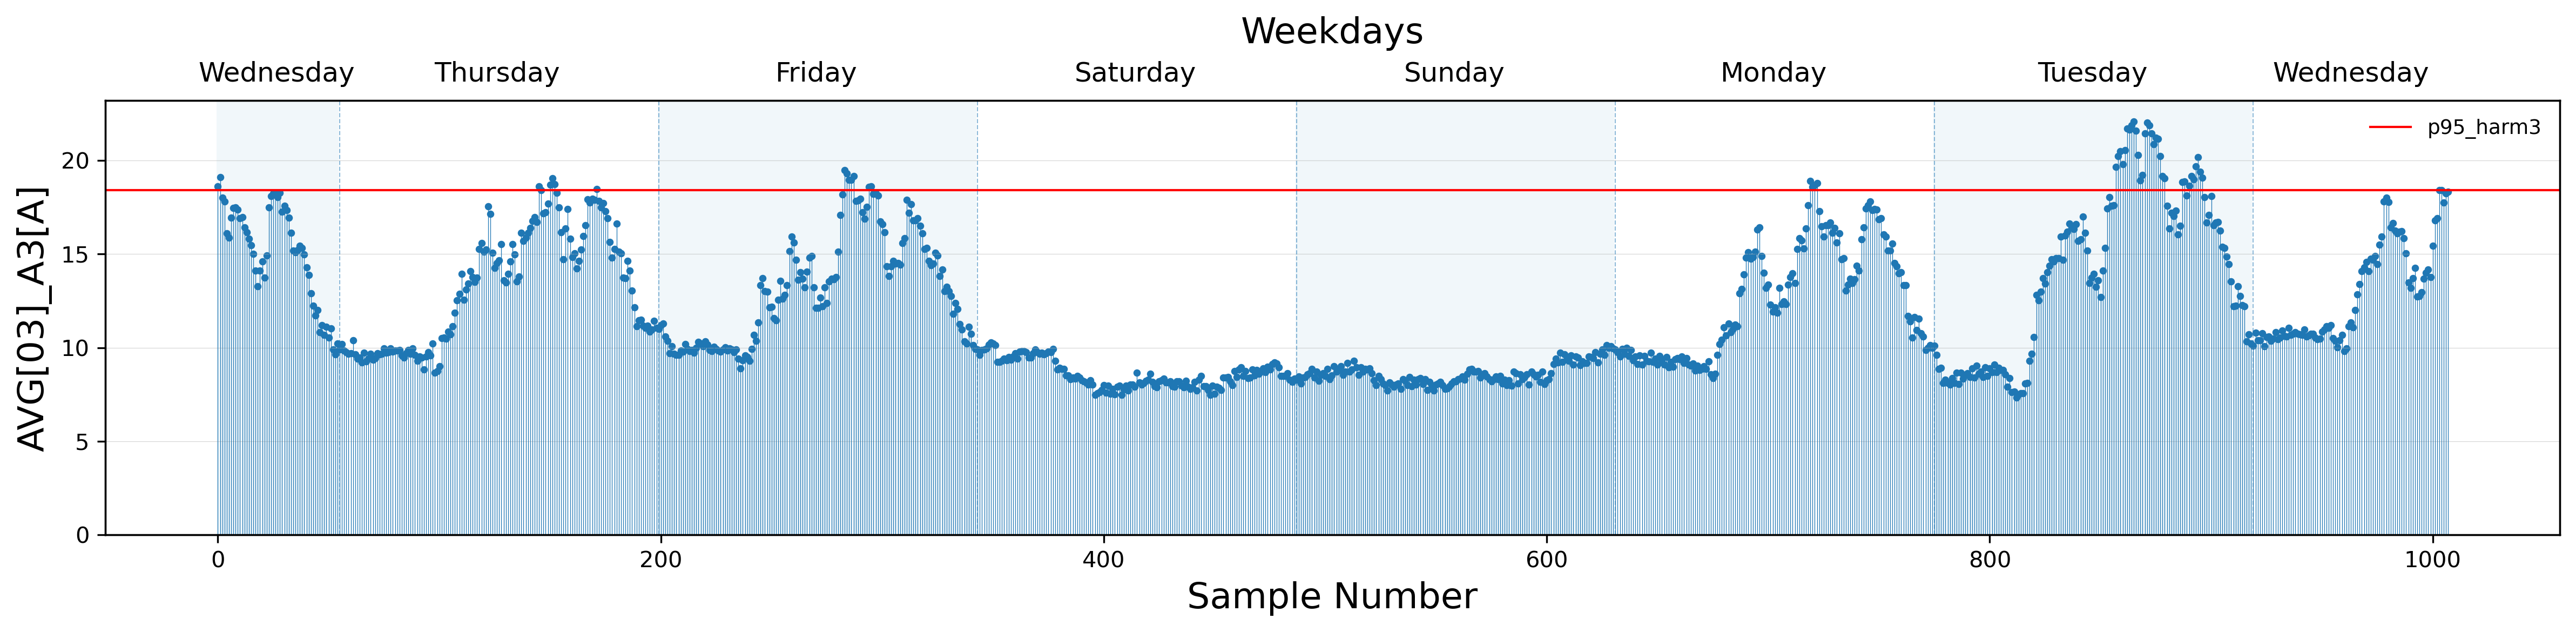

In [19]:
fig = plot_lollipop(data_IH, col_harm3, 'Weekday_EN', constant_line_value=p95_harm3, constant_line_label="p95_harm3", 
                    y_lim = (0, data_IH[col_harm3].max() + data_IH[col_harm3].max()*0.05))

# Harmonic Chart

In [20]:
def plot_harmonic_lollipop(
    df: pd.DataFrame,
    phase: str,
    unit: str = "[V]",              # "[A]" for current, "[V]" for voltage
    percentile: float = 0.95,
    exclude_fundamental: bool = True,
    figsize: tuple = (16, 5),
    dpi: int = 300,
    shade: bool = True,
    line_color: str = "C0",
    point_color: str = "C3",
    linewidth: float = 0.7,
    point_size: float = 30.0,
):

    # --- Select columns by unit ---
    cols = [c for c in df.columns if unit in c]
    if not cols:
        raise ValueError(f"No columns containing {unit} were found in the DataFrame.")

    # --- Optionally exclude the fundamental (assumed to be the first column) ---
    cols_to_plot = cols[1:] if (exclude_fundamental and len(cols) > 1) else cols
    if not cols_to_plot:
        raise ValueError("After excluding the fundamental, no columns remain to plot.")

    # --- Compute the desired percentile and drop NaNs ---
    values = df[cols_to_plot].quantile(percentile).dropna()

    # --- Extract harmonic labels (number inside the column name) ---
    def _extract_harmonic(col_name: str) -> str:
        m = re.search(r"(\d+)", col_name)
        if m:
            return m.group(1)
        return col_name.replace(unit, "").strip()

    harmonics = [_extract_harmonic(c) for c in values.index]

    # --- Auxiliary DataFrame for plotting ---
    df_percentiles = pd.DataFrame({
        "Harmonic": harmonics,
        "Value": values.values
    })
    df_percentiles["Sample"] = np.arange(len(df_percentiles))

    # --- Y-axis label according to unit ---
    if unit == "[A]":
        ylabel = "Current [A]"
    elif unit == "[V]":
        ylabel = "Voltage [V]"
    else:
        ylabel = f"Value {unit}"

    # --- Lollipop plot ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.vlines(
        df_percentiles["Sample"],
        0,
        df_percentiles["Value"],
        color=line_color,
        linewidth=linewidth
    )
    ax.scatter(
        df_percentiles["Sample"],
        df_percentiles["Value"],
        color=point_color,
        s=point_size,
        zorder=3
    )

    # --- Formatting ---
    ax.set_xticks(df_percentiles["Sample"])
    ax.set_xticklabels(
        df_percentiles["Harmonic"],
        rotation=45,
        ha="right",
        fontsize=12
    )
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel("Harmonic", fontsize=14)
    ax.set_title(
        f"{int(percentile * 100)}th Percentile of Harmonics - Phase {phase}",
        fontsize=16
    )
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)

    # --- Alternating shading ---
    if shade:
        for i in range(len(df_percentiles)):
            if i % 2 == 0:
                ax.axvspan(i - 0.5, i + 0.5, alpha=0.05, color="gray")

    plt.tight_layout()
    return fig, ax


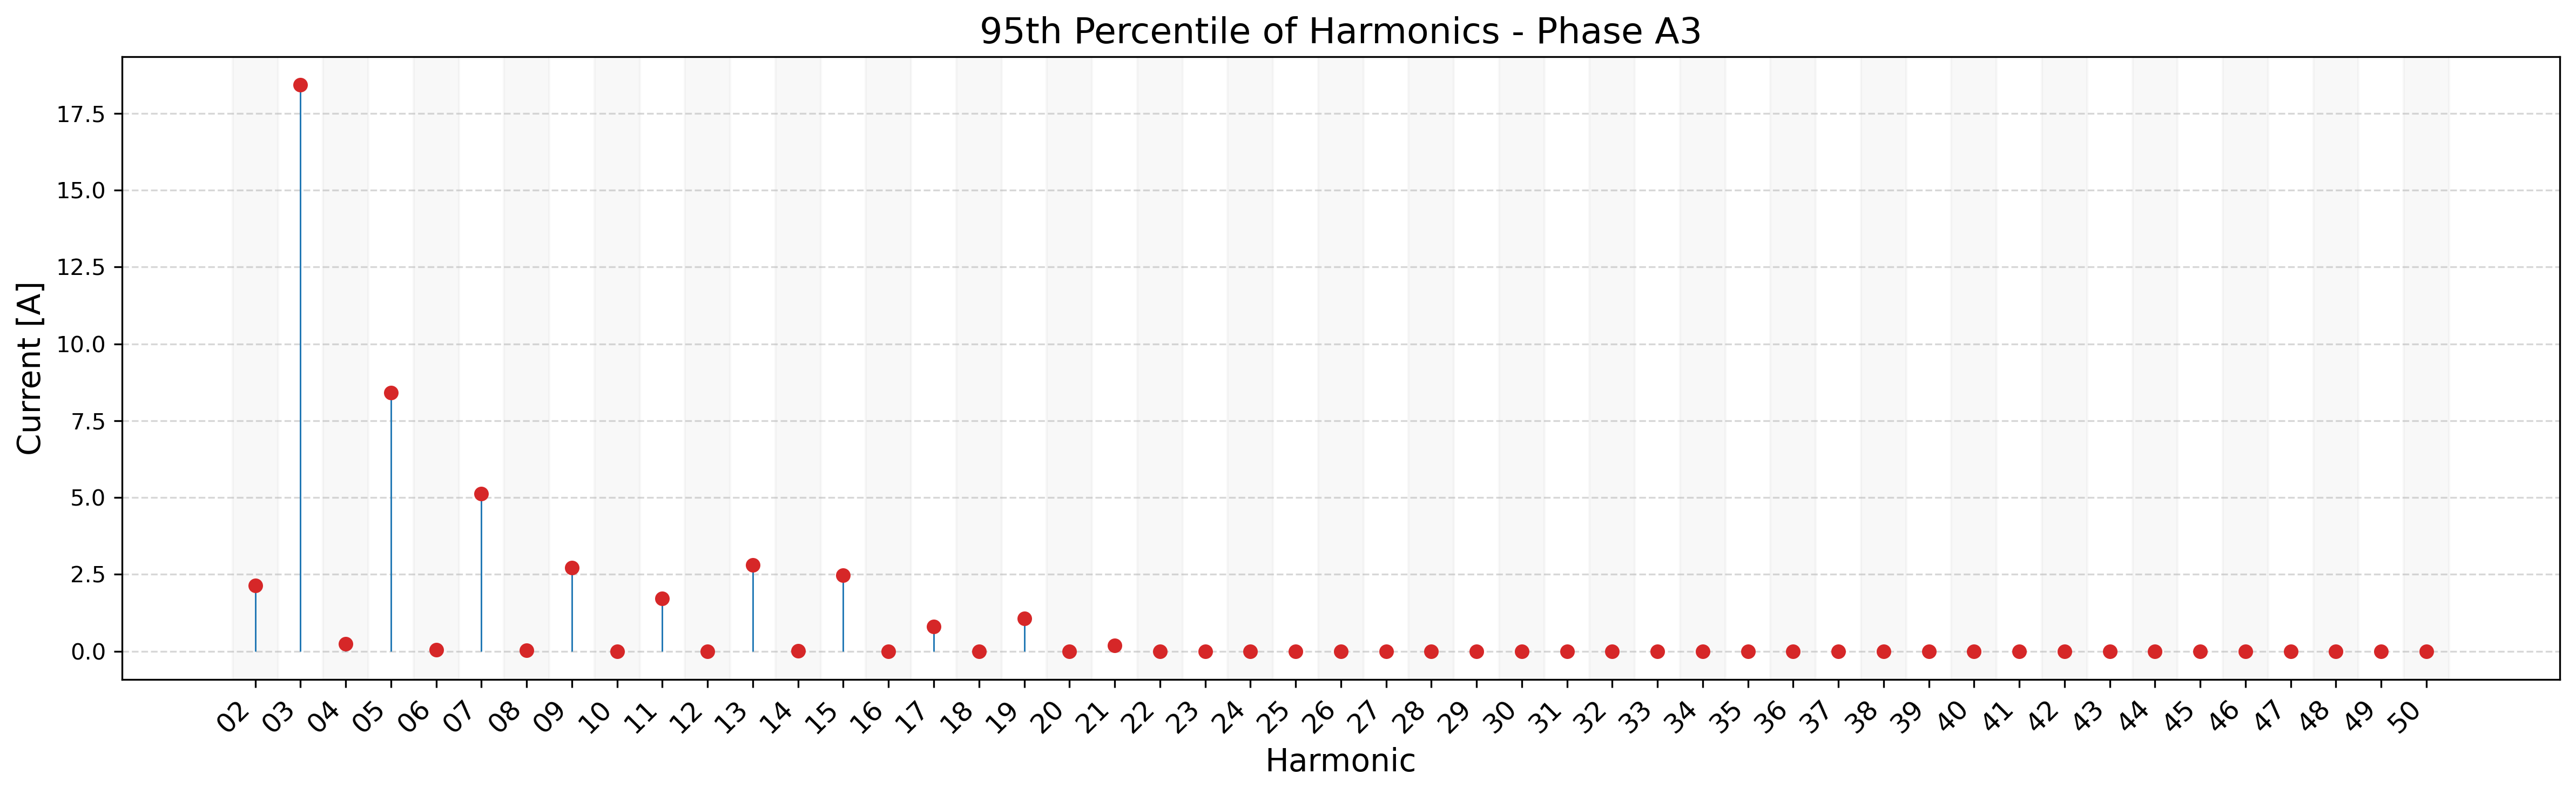

In [21]:
fig = plot_harmonic_lollipop(data_IH, phase, unit='[A]')

# Pie Chart – Harmonic Proportion


In [22]:
def harmonic_pie_chart_sns(
    df: pd.DataFrame,
    phase: str,
    unit: str = "[A]",
    percentile: float = 0.95,
    exclude_fundamental: bool = True,
    min_percent: float = 0.02,
    sort_by: str = "value",          # "value" (desc) or "harmonic" (asc)
    figsize: tuple = (5, 5),
    dpi: int = 150,
    show_value: bool = False,        # show absolute value in addition to %
    fontsize_legend: int = 11,
):
    """
    Pie chart of the proportion among harmonics with a Seaborn theme,
    legend shows harmonic and percentage, phase included in the title.
    """
    import seaborn as sns
    sns.set_theme(style="white")

    # --- Select columns by unit ---
    cols = [c for c in df.columns if unit in c]
    if not cols:
        raise ValueError(f"No columns with {unit} found in the DataFrame.")

    # --- Optionally ignore the fundamental ---
    cols_plot = cols[1:] if (exclude_fundamental and len(cols) > 1) else cols
    if not cols_plot:
        raise ValueError("After removing the fundamental, no columns remain to plot.")

    # --- Compute percentile and drop NaNs ---
    values = df[cols_plot].quantile(percentile).dropna()
    if values.empty:
        raise ValueError("No valid values for the computed percentile.")

    # --- Extract harmonic number ---
    def _extract_harmonic(col_name: str) -> int:
        m = re.search(r"(\d+)", col_name)
        return int(m.group(1)) if m else 0

    harmonic_nums = [_extract_harmonic(c) for c in values.index]

    aux = pd.DataFrame({"HarmonicNum": harmonic_nums, "Value": values.values})
    aux = aux[aux["Value"] > 0]
    if aux.empty:
        raise ValueError("All percentile values are zero; nothing to plot.")

    # --- Sorting ---
    if sort_by == "harmonic":
        aux = aux.sort_values("HarmonicNum", ascending=True)
    else:
        aux = aux.sort_values("Value", ascending=False)

    # --- Proportions and grouping small slices into "Others" ---
    total = aux["Value"].sum()
    aux["Proportion"] = aux["Value"] / total
    small = aux["Proportion"] < min_percent
    if small.any():
        other_val = aux.loc[small, "Value"].sum()
        other_prop = other_val / total
        aux = aux.loc[~small].copy()
        aux = pd.concat(
            [
                aux,
                pd.DataFrame(
                    {"HarmonicNum": [-1], "Value": [other_val], "Proportion": [other_prop]}
                ),
            ],
            ignore_index=True,
        )

    def _label(hn: int) -> str:
        return "Others" if hn == -1 else f"H{hn}"

    labels = [_label(h) for h in aux["HarmonicNum"]]
    proportions = aux["Proportion"].values

    # Prepare legend with percentage (and optional absolute value)
    legend_labels = []
    for lab, prop, val in zip(labels, proportions, aux["Value"]):
        pct = prop * 100
        text = f"{lab} ({pct:.1f}%)"
        if show_value:
            text += f" {val:.3g} {unit.strip('[]')}"
        legend_labels.append(text)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    colors = sns.color_palette("tab10", len(proportions))
    wedges = ax.pie(
        proportions,
        labels=None,  # labels moved to legend
        startangle=120,
        counterclock=False,
        colors=colors,
    )[0]

    ax.axis("equal")

    # --- Legend ---
    ax.legend(
        wedges,
        legend_labels,
        title=f"Harmonics",
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=fontsize_legend,
    )

    # --- Title with phase ---
    unit_title = (
        "Current [A]" if unit == "[A]" else ("Voltage [V]" if unit == "[V]" else f"Value {unit}")
    )
    ax.set_title(
        f"Harmonic Proportion (P{int(percentile*100)}) - Phase {phase}\n{unit_title}",
        fontsize=14,
        pad=10,
    )

    plt.tight_layout()
    return fig, ax


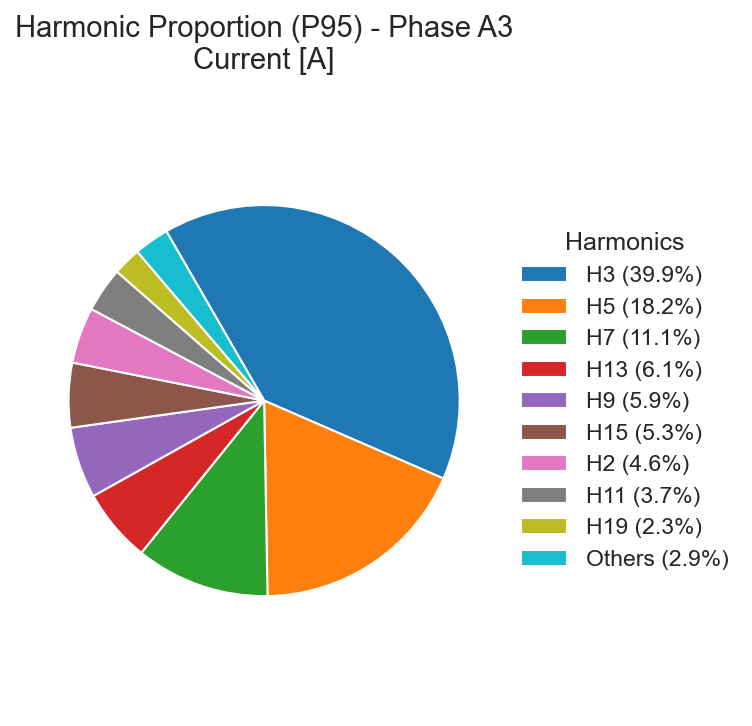

In [23]:
fig = harmonic_pie_chart_sns(data_IH, phase, unit='[A]', sort_by='valor')

# Pie Charts

In [24]:
def create_pie_chart_by_time_type_sns(
    df,
    column,
    flag_column,
    threshold_value,
    phase="",
    ax=None,
    startangle=90,
    figsize=(5, 5),
    legend_title="Category",
    title_fontsize=16,
    title_pad=10
):
    sns.set_theme(style="white")

    df = df.copy()
    df[flag_column] = np.where(df[column] > threshold_value, 1, 0)
    mask = df[flag_column] == 1

    counts = df.loc[mask, "Time_Type"].value_counts(dropna=False)
    counts = counts[counts > 0]

    if counts.sum() == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(f"{phase} | {column} > {threshold_value}", fontsize=title_fontsize, pad=title_pad)
        ax.axis("off")
        return ax

    # Ordenar em ordem decrescente
    counts = counts.sort_values(ascending=False)
    values = counts.values
    labels = counts.index.tolist()
    total = values.sum()
    percentages = values / total * 100

    legend_labels = [f"{label} ({pct:.1f}%)" for label, pct in zip(labels, percentages)]

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("tab10", len(values))

    wedges = ax.pie(
        values,
        labels=None,  # nada dentro da pizza
        startangle=startangle,
        counterclock=False,
        colors=colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
    )[0]

    ax.axis("equal")
    ax.set_title(f"{phase} | {column} > {threshold_value:.4f} by time of day",
                 fontsize=title_fontsize,
                 pad=title_pad)

    ax.legend(
        wedges,
        legend_labels,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    return ax


<Axes: title={'center': 'A3 | AVG[03]_A3[A] > 18.4205 by time of day'}>

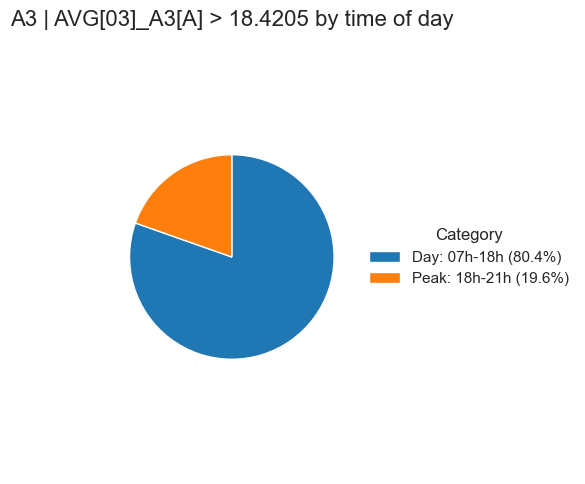

In [25]:
create_pie_chart_by_time_type_sns(data_IH, col_harm3, 'flag_DTT_%', p95_harm3, phase)

In [26]:
def create_pie_chart_by_weekday_sns(
    df,
    column,
    flag_column,
    threshold_value,
    phase="",
    ax=None,
    startangle=90,
    figsize=(5, 5),
    legend_title="Weekday",
    title_fontsize=16,
    title_pad=10
):

    sns.set_theme(style="white")

    order = [
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ]

    df = df.copy()
    df[flag_column] = np.where(df[column] > threshold_value, 1, 0)
    mask = df[flag_column] == 1

    s = df.loc[mask, "Weekday_EN"].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    counts = s.value_counts(sort=False)
    counts = counts[counts > 0]

    if counts.sum() == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(f"{phase} | {column} > {threshold_value}", fontsize=title_fontsize, pad=title_pad)
        ax.axis("off")
        return ax

    # Ordenar em ordem decrescente
    counts = counts.sort_values(ascending=False)
    values = counts.values
    labels = counts.index.tolist()
    total = values.sum()
    percentages = values / total * 100

    legend_labels = [
        f"{label} ({pct:.1f}%)"
        for label, pct in zip(labels, percentages)
    ]

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("tab10", len(values))

    wedges = ax.pie(
        values,
        labels=None,
        startangle=startangle,
        counterclock=False,
        colors=colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
    )[0]

    ax.axis("equal")
    ax.set_title(f"{phase} | {column} > {threshold_value:.4f} by weekday",
                 fontsize=title_fontsize,
                 pad=title_pad)

    ax.legend(
        wedges,
        legend_labels,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    return ax


<Axes: title={'center': 'A3 | AVG[03]_A3[A] > 18.4205 by weekday'}>

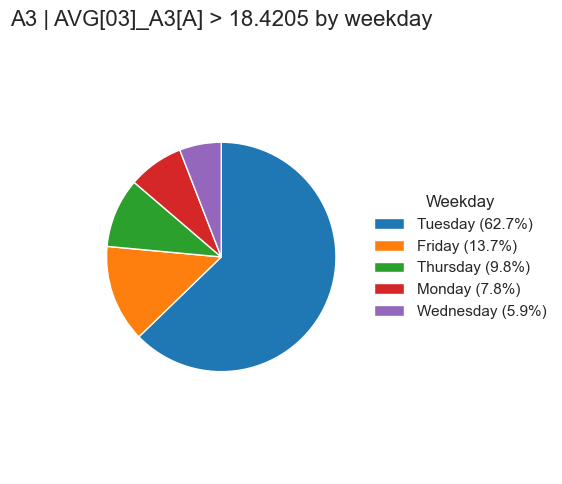

In [27]:
create_pie_chart_by_weekday_sns(data_IH, col_harm3, 'flag_DTT_%', p95_harm3, phase)